In [1]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed

import sys
import os
current = os.path.dirname(os.path.realpath('plotting.py'))
parent = os.path.dirname(current)
sys.path.append(parent)
import functions.plotting as NNplt
from functions.rnn_cryptic import generate_sequences, convert_seq2inputs, pad_seqs_2step

In [2]:
num_classes = 14
batchsize=5
# specs
input_size = num_classes
output_size = 1
hidden_size = 20
num_layers = 1
learningRate = 0.005


In [3]:
class OneStepRNN(nn.Module):

    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(OneStepRNN, self).__init__()
        # Define parameters
        self.rnn = torch.nn.RNN(input_size=input_size,
                        hidden_size=hidden_size,
                        num_layers= num_layers,
                        batch_first=True)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        # Define the layers
        self.input2hidden = nn.Linear(input_size + self.hidden_size, self.hidden_size)
        self.fc1tooutput = nn.Linear(self.hidden_size, output_size)

    def forward(self, x, hidden):
        combined = torch.cat((x, hidden), dim=0) ## dim = 1??
        self.hidden = nn.functional.relu(self.input2hidden(combined))
        self.output = self.fc1tooutput(self.hidden)
        #return self.output.view(-1,output_size), self.hidden
        return self.output, self.hidden

    def get_activations(self, x, hidden):
        self.forward(x, hidden)  # update the activations with the particular input
        return self.hidden, self.output #, self.fc1_activations

    def get_noise(self):
        return self.hidden_noise

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)[0]


def train(sequence,label,model,optimizer,criterion):
    model.train()
    optimizer.zero_grad()
    #Read each cue in and keep hidden state for next cue
    hidden = model.initHidden()
    batch_out = []
    for batchseq in sequence:
        for i in range(len(batchseq)):
            output, hidden = model.forward(batchseq[i], hidden)
        batch_out.append(output)
        #Compare final output to target
    batch_out = torch.cat(batch_out)
    loss = criterion(batch_out,label)#.long())

    #Back-propagate
    loss.backward()
    optimizer.step()

    return batch_out, loss.item()


def run(model, train_data, epochs):

    model.train()
    loss_history = []
    for epoch in range(epochs):
        lossTotal = 0
        for x,y in train_data:
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
        loss_history.append(lossTotal)

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history

def run_acc(model,optimizer,criterion, train_data, test_data, epochs, verbose = False):
    
    loss_history = np.empty((0,1))
    all_accs = np.empty((0,len(test_data)))
    for epoch in range(epochs):
        lossTotal = 0
        for i, (x,y) in enumerate(train_data):
            output, loss = train(x,y,model,optimizer,criterion)
            lossTotal += loss # add MSE -> sum of square errors 
            if (epoch%100 == 2):
                if i%50 == 0:
                    if verbose:
                        print('\n################\nepoch: ',epoch, '\n################\n')
                        print('output =. ' , output.detach().numpy())
                        print('label =. ' , y.detach().numpy())
                        test_acc(model, test_data, hidden_size, verbose = True)
        loss_history = np.vstack([loss_history, lossTotal])
        acc = test_acc(model, test_data, hidden_size)
        all_accs = np.vstack([all_accs,acc])

    print(f'loss: {round(lossTotal,1)} ')
    return loss_history, all_accs

def test_acc(model, testdata, hidden_size, verbose = False):
    model.eval()
    accs = np.empty((1, 0))
    for testset in testdata:
        batch_correct = []
        for x,y in testset:
            correct = 0
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct += sum(torch.round(y[i]) == torch.round(y_hat)).item()
            batch_correct.append(correct/len(y))
        acc = np.mean(batch_correct)
        accs = np.append(accs, [acc])
    if verbose:
        print('test accuracy: %f ' % (acc))
    return accs


def shuffle_weights(model):
    model2 = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    mod_dict = model.state_dict()
    shuffled_dict = {layer: shuffle_tensor(val) for layer, val in mod_dict.items()}
    model2.load_state_dict(shuffled_dict)
    return model2

def shuffle_tensor(t):
    idx = torch.randperm(t.nelement())
    t = t.view(-1)[idx].view(t.size())
    return t

# def run_sim(i):
#     print('########## rep ', i, '##########')
#     model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
#     criterion = nn.MSELoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
#     loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
#     loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
#     losses = loss1+loss2
#     accs = np.vstack([acc1,acc2])
#     return losses, accs

def run_sim(i):
    print('########## rep ', i, '##########')
    model = OneStepRNN(input_size, output_size, hidden_size, num_layers)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
    loss1, acc1 = run_acc(model,optimizer,criterion, trainset[0], test_sets, epochs)
    loss2, acc2 = run_acc(model,optimizer,criterion, trainset[1], test_sets, epochs)
    losses = np.vstack([loss1,loss2])
    accs = np.vstack([acc1,acc2])

    return losses, accs, model


def seq_acc(model, testset, hidden_size, rep = 10, verbose = False):
    
    train_inputs = convert_seq2inputs(testset, num_classes=num_classes, seq_len=8)
    testdata = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
    model.eval()
    trials = []
    accs = []
    for _ in range(rep):
        for j, (x,y) in enumerate(testdata):
            for i in range(len(x)):
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                correct = sum(torch.round(y[i]) == torch.round(y_hat)).item() 
                accs.append(float(correct))
                curr_trial = testset[4*j+i].copy()
                trials.append([x for x in curr_trial if x!= ('X', 'X')])
#                 trials.append(curr_trial)
    
    df = pd.DataFrame({'trial':trials, 'acc':accs})
    df['trial'] = df['trial'].apply(str)
    df = df.groupby(['trial']).mean().sort_values(by = 'acc', ascending=False)
                
    return df 

In [78]:
def runT(T, epochs, num_sims):
    
    t1 = time.time()
    Tres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
    # train on 1 position
    t2 = time.time()
    print('time: ', (t2-t1)/60)
    
    if T == 'M':
        Tlosses = np.hstack([Tres[i][0] for i in range(len(Tres))])
        Ttrain = np.array([Tres[i][1][:,0] for i in range(len(Tres))]).T
        Tcombos = np.array([Tres[i][1][:,1] for i in range(len(Tres))]).T
        Torder = np.array([Tres[i][1][:,2] for i in range(len(Tres))]).T
        Tinit = np.array([Tres[i][1][:,3] for i in range(len(Tres))]).T

        print('train final acc:  ', np.mean(Ttrain[-1,:]))
        print('combos final acc:  ', np.mean(Tcombos[-1,:]))
        print('order final acc:  ', np.mean(Torder[-1,:]))
        print('init final acc:  ', np.mean(Tinit[-1,:]))

        return Tlosses, Ttrain, Tcombos, Tcombos, Tinit, Tres[-1]
        
    elif T == 'MC' or T == 'DC':
        Tlosses = np.hstack([Tres[i][0] for i in range(len(Tres))])
        Ttrain = np.array([Tres[i][1][:,0] for i in range(len(Tres))]).T
        Torder = np.array([Tres[i][1][:,1] for i in range(len(Tres))]).T
        Tinit = np.array([Tres[i][1][:,2] for i in range(len(Tres))]).T

        print('train final acc:  ', np.mean(Ttrain[-1,:]))
        print('order final acc:  ', np.mean(Torder[-1,:]))
        print('init final acc:  ', np.mean(Tinit[-1,:]))

        return Tlosses, Ttrain, Torder, Tinit, Tres[-1]
        
    elif T == 'F':
        Tlosses = np.hstack([Tres[i][0] for i in range(len(Tres))])
        Ttrain = np.array([Tres[i][1][:,0] for i in range(len(Tres))]).T
        Tinit = np.array([Tres[i][1][:,1] for i in range(len(Tres))]).T

        print('train final acc:  ', np.mean(Ttrain[-1,:]))
        print('init final acc:  ', np.mean(Tinit[-1,:]))

        return Tlosses, Ttrain, Tinit, Tres[-1]
    
def plotNNs(loss_arrays, acc_arrays, labels, colors, title, shift = 0):

    fig, axs = plt.subplots(2, 1)
    loss_cols = ['blue', 'darkblue', 'black']
    for i, arr in enumerate(loss_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[0].plot(x, mn, label = 'loss', color = loss_cols[i])
        axs[0].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = loss_cols[i])
    
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')
    axs[0].legend()
    
    for i, arr in enumerate(acc_arrays):
        x = np.arange(0,arr.shape[0],1) + shift
        mn = arr.mean(axis=1)
        errs = arr.std(axis=1)
        
        axs[1].plot(x, mn, label = labels[i], color = colors[i])
        axs[1].fill_between(x, mn - errs, mn + errs, alpha = 0.3, facecolor = colors[i])
    
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')
    axs[1].legend()

    fig.suptitle(title, fontsize=14)

# Read sequences

In [5]:
pretrainpath = '../sequences/pretraining/'

with open(pretrainpath+'type2_3', 'rb') as f:
    type2_3 = pickle.load(f)
with open(pretrainpath+'type2_12', 'rb') as f:
    type2_12 = pickle.load(f)
with open(pretrainpath+'type2_48', 'rb') as f:
    type2_48 = pickle.load(f)

# Load Training and Test data
trianpath = '../sequences/training/'


#Mset
with open(trianpath + 'Mset', 'rb') as f:
    Mset = pickle.load(f)
with open(trianpath + 'Mcombos', 'rb') as f:
    Mcombos = pickle.load(f)
with open(trianpath + 'Morder', 'rb') as f:
    Morder = pickle.load(f)
with open(trianpath + 'Minit', 'rb') as f:
    Minit = pickle.load(f)

# MC set
with open(trianpath + 'MCset', 'rb') as f:
    MCset = pickle.load(f)
with open(trianpath + 'MCorder', 'rb') as f:
    MCorder = pickle.load(f)
with open(trianpath + 'MCinit', 'rb') as f:
    MCinit = pickle.load(f)
    
# DC set
with open(trianpath + 'DCset', 'rb') as f:
    DCset = pickle.load(f)
with open(trianpath + 'DCorder', 'rb') as f:
    DCorder = pickle.load(f)
with open(trianpath + 'DCinit', 'rb') as f:
    DCinit = pickle.load(f)

# F set
with open(trianpath + 'Fset', 'rb') as f:
    Fset = pickle.load(f)
with open(trianpath + 'Finit', 'rb') as f:
    Finit = pickle.load(f)

In [6]:
# convert sequences to inputs 

# Pretraining
padtype2_3 = pad_seqs_2step(type2_3)
train_inputs = convert_seq2inputs(padtype2_3, num_classes=num_classes, seq_len=8)
trainT2_3 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtype2_12 = pad_seqs_2step(type2_12)
train_inputs = convert_seq2inputs(padtype2_12, num_classes=num_classes, seq_len=8)
trainT2_12 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

padtype2_48 = pad_seqs_2step(type2_48)
train_inputs = convert_seq2inputs(padtype2_48, num_classes=num_classes, seq_len=8)
trainT2_48 = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Mset
# Mset
train_inputs = convert_seq2inputs(Mset, num_classes=num_classes, seq_len=7)
trainMset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Mcombos, num_classes=num_classes, seq_len=7)
testMcombos = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Morder, num_classes=num_classes, seq_len=7)
testMorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Minit, num_classes=num_classes, seq_len=7)
testMinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# MCaset
train_inputs = convert_seq2inputs(MCset, num_classes=num_classes, seq_len=7)
trainMCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCorder, num_classes=num_classes, seq_len=7)
testMCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(MCinit, num_classes=num_classes, seq_len=7)
testMCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# DCaset
train_inputs = convert_seq2inputs(DCset, num_classes=num_classes, seq_len=7)
trainDCset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCorder, num_classes=num_classes, seq_len=7)
testDCorder = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(DCinit, num_classes=num_classes, seq_len=7)
testDCinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

# Fset
train_inputs = convert_seq2inputs(Fset, num_classes=num_classes, seq_len=7)
trainFset = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)

train_inputs = convert_seq2inputs(Finit, num_classes=num_classes, seq_len=7)
testFinit = DataLoader(train_inputs, batch_size=batchsize, shuffle=True)


# Pretrain T2_3

In [ ]:
########## Mset #############

In [92]:
epochs = 500
num_sims = 8

trainset = [trainT2_3, trainMset]
test_sets = [trainMset, testMcombos, testMorder, testMinit]
t23Mlosses, t23Mtrain, t23Mcombos, t23Morder, t23Minit, t23Mmods = \
                    runT(T='M', epochs=epochs, num_sims=num_sims)

plotNNs([t23Mlosses],[t23Mtrain,  t23Mcombos, t23Morder, t23Minit],\
                    labels = ['train', 'combos','order', 'init'],\
                    colors = ['green','purple','orange', 'red'],\
                    title = 'type2_3 pretraining, M training',\
                    shift = 0)


In [ ]:
########## MCset #############

In [129]:
epochs = 1500
num_sims = 8

trainset = [trainT2_3, trainMCset]
test_sets = [trainMCset, testMCorder, testMCinit]
t23MClosses, t23MCtrain, t23MCorder, t23MCinit, t23MCmods = \
                    runT(T='MC', epochs=epochs, num_sims=num_sims)


train final acc:   1.0
order final acc:   0.0
init final acc:   0.16666666666666666


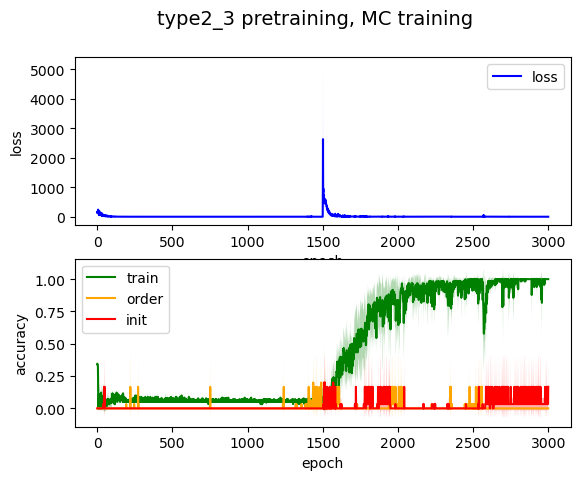

In [128]:
acc_mods = t23MCtrain[-1,:]>0.95
print('train final acc:  ', np.mean(t23MCtrain[:,acc_mods][-1,:]))
print('order final acc:  ', np.mean(t23MCorder[:,acc_mods][-1,:]))
print('init final acc:  ', np.mean(t23MCinit[:,acc_mods][-1,:]))
plotNNs([t23MClosses[:, acc_mods]],[t23MCtrain[:, acc_mods],  t23MCorder[:, acc_mods], t23MCinit[:, acc_mods]],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_3 pretraining, MC training',\
                    shift = 0)


In [ ]:
# DC set #################

In [133]:
epochs = 12000
num_sims = 5

trainset = [trainT2_3, trainDCset]
test_sets = [trainDCset, testDCorder, testDCinit]
t23DClosses, t23DCtrain, t23DCorder, t23DCinit, t23DCmods = \
                    runT(T='DC', epochs=epochs, num_sims=num_sims)



In [ ]:
plotNNs([t23DClosses],[t23DCtrain,  t23DCorder, t23DCinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_3 pretraining, DC training',\
                    shift = 0)


In [12]:
epochs = 12000
num_sims = 5

trainset = [trainT2_3, trainDCset]
test_sets = [trainDCset, testDCorder, testDCinit]

t1 = time.time()
t23DCres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

t23DClosses = np.hstack([t23DCres[i][0] for i in range(len(t23DCres))])
t23DCtrain = np.array([t23DCres[i][1][:,0] for i in range(len(t23DCres))]).T
t23DCorder = np.array([t23DCres[i][1][:,1] for i in range(len(t23DCres))]).T
t23DCinit = np.array([t23DCres[i][1][:,2] for i in range(len(t23DCres))]).T

time:  19.716960636774697


In [16]:
print('train final acc:  ', np.mean(t23DCtrain[-1,:]))
print('order final acc:  ', np.mean(t23DCorder[-1,:]))
print('init final acc:  ', np.mean(t23DCinit[-1,:]))

train final acc:   0.975
order final acc:   0.13333333333333333
init final acc:   0.013333333333333332


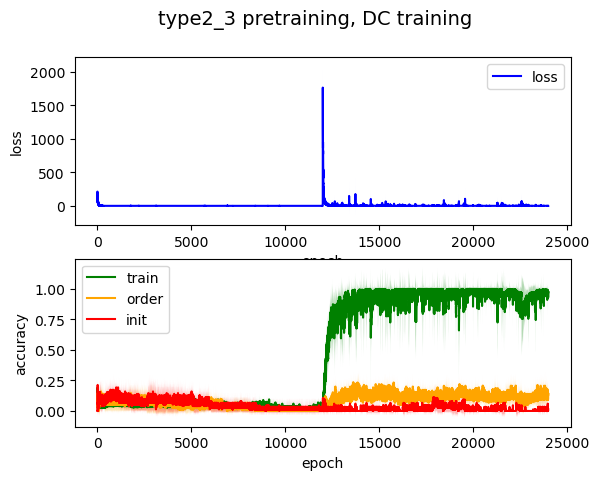

In [131]:
plotNNs([t23DClosses],[t23DCtrain,  t23DCorder, t23DCinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_3 pretraining, DC training',\
                    shift = 0)


In [ ]:
# F set ##############

In [ ]:
epochs = 9000
num_sims = 5

trainset = [trainT2_3, trainFset]
test_sets = [trainFset, testForder, testFinit]

t1 = time.time()
t23Fres = Parallel(n_jobs = -1)(delayed(run_sim)(i) for i in range(num_sims))
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)

t23Flosses = np.hstack([t23Fres[i][0] for i in range(len(t23Fres))])
t23Ftrain = np.array([t23Fres[i][1][:,0] for i in range(len(t23Fres))]).T
t23Finit = np.array([t23Fres[i][1][:,1] for i in range(len(t23Fres))]).T

print('train final acc:  ', np.mean(t23Ftrain[-1,:]))
print('order final acc:  ', np.mean(t23Forder[-1,:]))
print('init final acc:  ', np.mean(t23Finit[-1,:]))



# Type 2_12

In [ ]:
# M set ###############

In [39]:
epochs = 500
num_sims = 5

trainset = [trainT2_12, trainMset]
test_sets = [trainMset, testMcombos, testMorder, testMinit]
t212Mlosses, t212MTtrain, t212MTcombos, t212MTorder, t212MTinit, t212Mmods = \
                    runT(T='M', epochs=epochs, num_sims=num_sims)


time:  0.2589923143386841
train final acc:   1.0
combos final acc:   0.1
order final acc:   0.2
init final acc:   0.0


<Figure size 400x1200 with 0 Axes>

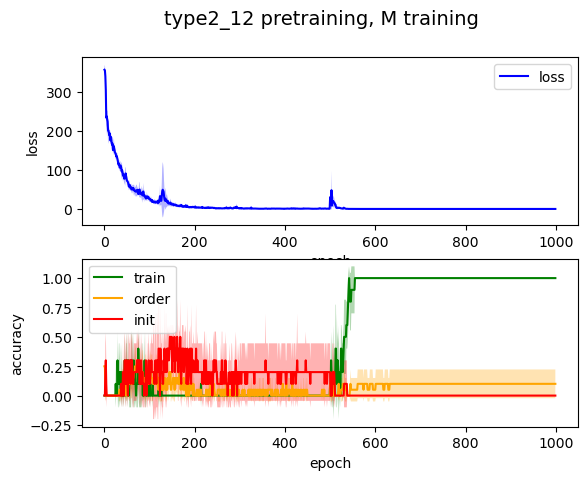

In [110]:
plt.figure(figsize = (4, 12))
plotNNs([t212Mlosses],[t212MTtrain,  t212MTorder, t212MTinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_12 pretraining, M training',\
                    shift = 0)


In [ ]:
# MC ##########

In [87]:
epochs = 1700
num_sims = 8

trainset = [trainT2_12, trainMCset]
test_sets = [trainMCset, testMCorder, testMCinit]
t212MClosses, t212MCtrain, t212MCorder, t212MCinit, t212MCmods = \
                    runT(T='MC', epochs=epochs, num_sims=num_sims)


time:  2.8136154651641845
train final acc:   1.0
order final acc:   0.0
init final acc:   0.0125


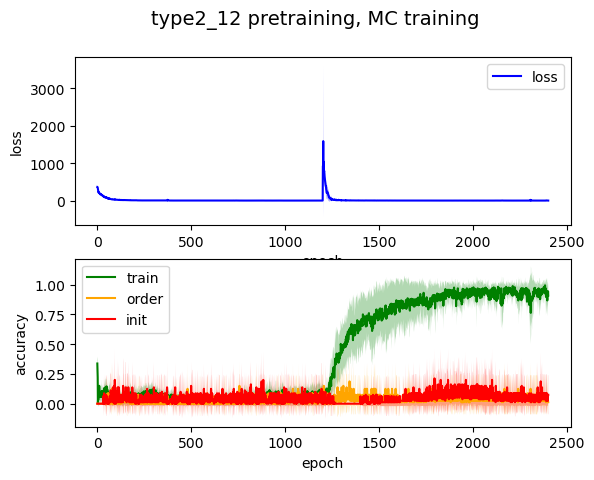

In [86]:
plotNNs([t212MClosses],[t212MCtrain,  t212MCorder, t212MCinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_12 pretraining, MC training',\
                    shift = 0)


In [ ]:
# DC ###################

time:  5.4384370366732275
train final acc:   0.8843749999999999
order final acc:   0.08333333333333334
init final acc:   0.016666666666666666


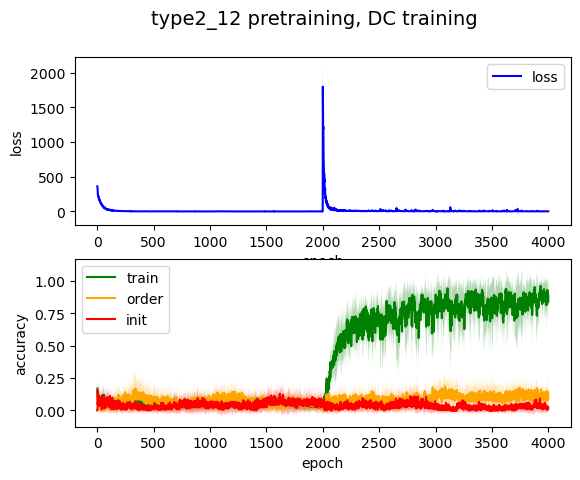

In [138]:
epochs = 2000
num_sims = 8

trainset = [trainT2_12, trainDCset]
test_sets = [trainDCset, testDCorder, testDCinit]
t212DClosses, t212DCtrain, t212DCorder, t212DCinit, t212DCmods = \
                    runT(T='DC', epochs=epochs, num_sims=num_sims)



train final acc:   0.9833333333333334
order final acc:   0.13333333333333333
init final acc:   0.044444444444444446


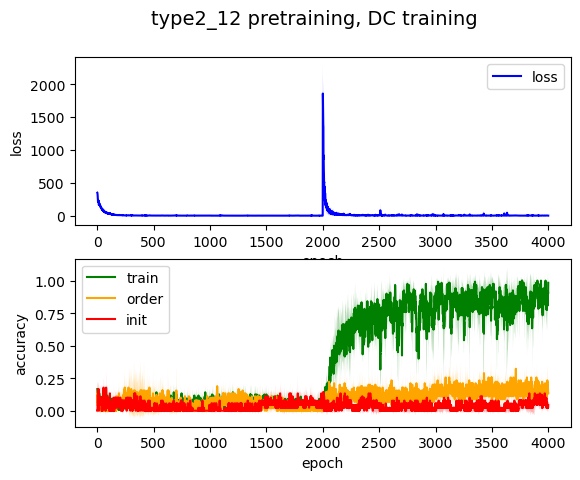

In [142]:
acc_mods = t212DCtrain[-1,:]>0.95
print('train final acc:  ', np.mean(t212DCtrain[:,acc_mods][-1,:]))
print('order final acc:  ', np.mean(t212DCorder[:,acc_mods][-1,:]))
print('init final acc:  ', np.mean(t212DCinit[:,acc_mods][-1,:]))
plotNNs([t212DClosses[:, acc_mods]],\
        [t212DCtrain[:, acc_mods],  t212DCorder[:, acc_mods], t212DCinit[:, acc_mods]],\
                labels = ['train', 'order', 'init'],\
                colors = ['green','orange', 'red'],\
                title = 'type2_12 pretraining, DC training',\
                shift = 0)


In [63]:
# F ##############

In [ ]:
epochs = 1200
num_sims = 8

trainset = [trainT2_12, trainFset]
test_sets = [trainFset, testForder, testFinit]
t212Flosses, t212Ftrain, t212Forder, t212Finit, t212Fmods = \
                    runT(T='F', epochs=epochs, num_sims=num_sims)

plotNNs([t212Flosses],[t212Ftrain,  t212Forder, t212Finit],\
                    labels = ['train', 'init'],\
                    colors = ['green','red'],\
                    title = 'type2_12 pretraining, F training',\
                    shift = 0)


# Type2_48

In [ ]:
# M ############

time:  1.0684752702713012
train final acc:   1.0
combos final acc:   0.09375
order final acc:   0.25
init final acc:   0.0


<Figure size 400x1200 with 0 Axes>

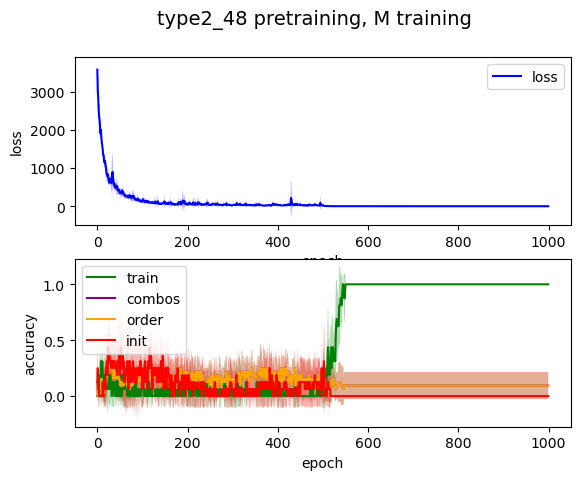

In [144]:
epochs = 500
num_sims = 8

trainset = [trainT2_48, trainMset]
test_sets = [trainMset, testMcombos, testMorder, testMinit]
t248Mlosses, t248Mtrain, t248Mcombos, t248Morder, t248Minit, t248Mmods = \
                    runT(T='M', epochs=epochs, num_sims=num_sims)

plt.figure(figsize = (4, 12))
plotNNs([t248Mlosses],[t248Mtrain,  t248Mcombos, t248Morder, t248Minit],\
                    labels = ['train', 'combos','order', 'init'],\
                    colors = ['green','purple','orange', 'red'],\
                    title = 'type2_48 pretraining, M training',\
                    shift = 0)



In [ ]:
# MC #########

In [150]:
epochs = 1400
num_sims = 8

trainset = [trainT2_12, trainMCset]
test_sets = [trainMCset, testMCorder, testMCinit]
t248MClosses, t248MCtrain, t248MCorder, t248MCinit, t248MCmods = \
                    runT(T='MC', epochs=epochs, num_sims=num_sims)

plotNNs([t248MClosses],[t248MCtrain,  t248MCorder, t248MCinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_12 pretraining, MC training',\
                    shift = 0)


train final acc:   1.0
order final acc:   0.025
init final acc:   0.0


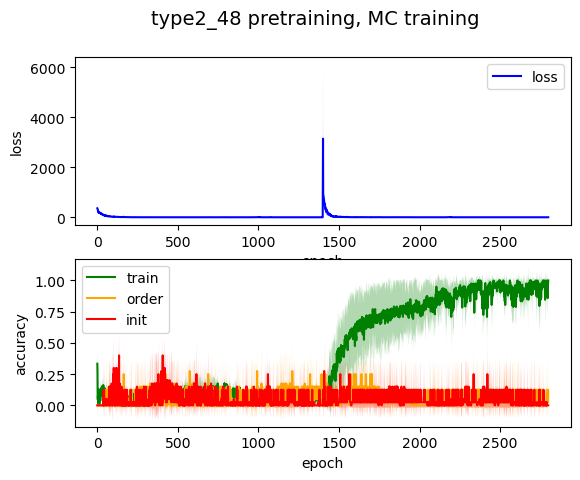

In [151]:
acc_mods = t248MCtrain[-1,:]>0.95

print('train final acc:  ', np.mean(t248MCtrain[:,acc_mods][-1,:]))
print('order final acc:  ', np.mean(t248MCorder[:,acc_mods][-1,:]))
print('init final acc:  ', np.mean(t248MCinit[:,acc_mods][-1,:]))
plotNNs([t248MClosses[:, acc_mods]],\
        [t248MCtrain[:, acc_mods],  t248MCorder[:, acc_mods], t248MCinit[:, acc_mods]],\
                labels = ['train', 'order', 'init'],\
                colors = ['green','orange', 'red'],\
                title = 'type2_48 pretraining, MC training',\
                shift = 0)


In [ ]:
# DC ##############

time:  7.2440211852391565
train final acc:   0.8968750000000001
order final acc:   0.09583333333333334
init final acc:   0.07083333333333333


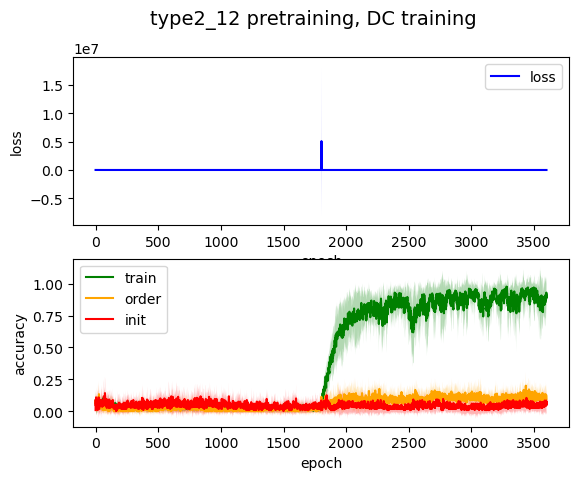

In [153]:
epochs = 1800
num_sims = 8

trainset = [trainT2_48, trainDCset]
test_sets = [trainDCset, testDCorder, testDCinit]
t248DClosses, t248DCtrain, t248DCorder, t248DCinit, t248DCmods = \
                    runT(T='DC', epochs=epochs, num_sims=num_sims)

plotNNs([t248DClosses],[t248DCtrain,  t248DCorder, t248DCinit],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_12 pretraining, DC training',\
                    shift = 0)


train final acc:   0.99375
order final acc:   0.1
init final acc:   0.03333333333333333


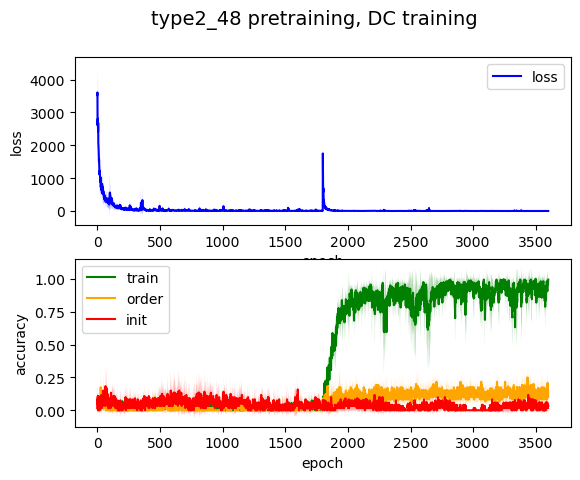

In [157]:
acc_mods = t248DCtrain[-1,:]>0.95
print('train final acc:  ', np.mean(t248DCtrain[:,acc_mods][-1,:]))
print('order final acc:  ', np.mean(t248DCorder[:,acc_mods][-1,:]))
print('init final acc:  ', np.mean(t248DCinit[:,acc_mods][-1,:]))


plotNNs([t248DClosses[:,acc_mods]],[t248DCtrain[:,acc_mods],  t248DCorder[:,acc_mods], t248DCinit[:,acc_mods]],\
                    labels = ['train', 'order', 'init'],\
                    colors = ['green','orange', 'red'],\
                    title = 'type2_48 pretraining, DC training',\
                    shift = 0)


In [155]:
t248DCtrain[-1,:]

array([1.   , 0.925, 0.875, 0.475, 1.   , 1.   , 0.975, 0.925])

########## rep  3 ##########
loss: 4.5 
loss: 2.1 
########## rep  1 ##########
loss: 2.7 
loss: 0.9 
########## rep  7 ##########
loss: 4.4 
loss: 1.0 
########## rep  2 ##########
loss: 11.2 
loss: 0.7 
########## rep  4 ##########
loss: 24.7 
loss: 0.2 
########## rep  6 ##########
loss: 1.6 
loss: 0.3 
########## rep  5 ##########
loss: 5.4 
loss: 0.2 
########## rep  0 ##########
loss: 0.9 
loss: 0.6 


In [ ]:
# F #############

In [135]:
epochs = 1200
num_sims = 8

trainset = [trainT2_48, trainFset]
test_sets = [trainFset, testForder, testFinit]
t248Flosses, t248Ftrain, t248Forder, t248Finit, t248Fmods = \
                    runT(T='F', epochs=epochs, num_sims=num_sims)

plotNNs([t248Flosses],[t248Ftrain,  t248Forder, t248Finit],\
                    labels = ['train', 'init'],\
                    colors = ['green','red'],\
                    title = 'type2_12 pretraining, F training',\
                    shift = 0)


NameError: name 'testForder' is not defined

In [ ]:
%load_ext line_profiler

In [ ]:
%lprun -f model.forward run_sim(1)

In [59]:
epochs = 700
num_sims = 1

trainset = [trainT2_3, trainMCset]
test_sets = [trainMCset, testMCinit]

t1 = time.time()
t23FFFres = run_sim(1)
# train on 1 position
t2 = time.time()
print('time: ', (t2-t1)/60)



########## rep  1 ##########
loss: 0.0 
loss: 0.5 
time:  0.4155473351478577
